In [ ]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib
import folium
import warnings
# from statsmodels.tools.sm_exceptions import ConvergenceWarning
# warnings.simplefilter('ignore', ConvergenceWarning)
from sklearn.model_selection import TimeSeriesSplit
%matplotlib inline

In [2]:
df_raw = pd.read_csv('zillow_data.csv')
df_raw.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
# Import zipcode database to pair with data
df_Zipcode = pd.read_csv('zip_code_database.csv')

In [4]:
# Rename RegionName to Zipcode to merge data from zip code import
df_raw.rename(columns={'RegionName': 'Zipcode'}, inplace = True)

In [5]:
# Drop other columns and keep Zipcode (for merge), Lat/Long, and estimated Population
df_Zipcode.rename(columns={'zip':'Zipcode'}, inplace = True)
df_Zipcode = df_Zipcode[['Zipcode', 'latitude', 'longitude', 'irs_estimated_population' ]]
df_Zipcode.head()

,Zipcode,latitude,longitude,irs_estimated_population
0,501,40.81,-73.04,562
1,544,40.81,-73.04,0
2,601,18.16,-66.72,0
3,602,18.38,-67.18,0
4,603,18.43,-67.15,0


In [6]:
df = df_raw.merge(df_Zipcode, on = 'Zipcode')
df.head()


,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1009600,1013300,1018700,1024400,1030700,1033800,1030600,41.94,-87.65,54760
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,314100,315000,316600,318100,319600,321100,321800,33.17,-96.70,56810
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,320400,320800,321200,321200,323000,326900,329900,29.74,-95.83,125330
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1291500,1296600,1299000,1302700,1306400,1308500,1307000,41.92,-87.65,52800
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,120300,120300,120300,120300,120500,121000,121500,31.78,-106.30,99590


In [8]:
#Dividing zipcodes into region 
df_East = df[df_raw.Zipcode < 50000]
df_Central = df[(df_raw.Zipcode >= 50000) & (df_raw.Zipcode < 80000) ]
df_West = df[(df.Zipcode >= 80000)]

#Cenral** 
df_Central.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1009600,1013300,1018700,1024400,1030700,1033800,1030600,41.94,-87.65,54760
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,314100,315000,316600,318100,319600,321100,321800,33.17,-96.70,56810
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,320400,320800,321200,321200,323000,326900,329900,29.74,-95.83,125330
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1291500,1296600,1299000,1302700,1306400,1308500,1307000,41.92,-87.65,52800
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,120300,120300,120300,120300,120500,121000,121500,31.78,-106.30,99590


In [12]:
# Texas Data frame
TX_df_uf = df_Central[(df_Central['State'] == 'TX')]
TX_df_uf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 989 entries, 1 to 14695
Columns: 275 entries, RegionID to irs_estimated_population
dtypes: float64(221), int64(50), object(4)
memory usage: 2.1+ MB


In [13]:
print(TX_df_uf.shape)
TX_df_uf.head()

(989, 275)


,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,314100,315000,316600,318100,319600,321100,321800,33.17,-96.70,56810
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,320400,320800,321200,321200,323000,326900,329900,29.74,-95.83,125330
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,120300,120300,120300,120300,120500,121000,121500,31.78,-106.30,99590
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,161900,162800,162800,162800,162900,163500,164300,29.83,-95.66,99740
8,91940,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,95800.0,...,169600,170900,172300,173300,174200,175400,176200,29.84,-95.73,119990


# Filtering results through Population Density, Price Percentile


In [14]:
#Population Density
TX_df_uf['irs_estimated_population'].mean()

22955.625884732053

In [15]:
TX_df_uf['irs_estimated_population'].median()


19100.0

In [16]:
TX_dff = TX_df_uf[(TX_df_uf.irs_estimated_population >= 23000)]

In [17]:
# Price Percentile. Using 25%-75%

TX_dff['yr_avg']=TX_dff.iloc[:,-12:].mean(skipna=True, axis=1)
#Get zipcodes with an average value 1 decile above the median and 1.5 deciles below.
print(TX_dff['yr_avg'].describe(),'\n')
#Calculate the 75% cutoff value (1 decile above).
q_75 = TX_dff['yr_avg'].quantile(q=0.75)
print(f'Average Value 75% cutoff value: {round(q_75,2)}')
#Calculate the 25% cutoff value (1.5 deciles below).
q_25 = TX_dff['yr_avg'].quantile(q=0.25)
print(f'Average Value 25% cutoff value: {round(q_25,2)}')
#Get data frame with selected zipcodes.
TX_dff1 = TX_dff[(TX_dff['yr_avg']<q_75) & (TX_dff['yr_avg']>q_25)]
print(f'Amount of zipcodes: {len(TX_dff1)}')


count       411.000000
mean     169695.430645
std       91120.937475
min       46875.505833
25%      108078.317083
50%      147872.130000
75%      202451.337917
max      787770.355000
Name: yr_avg, dtype: float64 

Average Value 75% cutoff value: 202451.34
Average Value 25% cutoff value: 108078.32
Amount of zipcodes: 205


<ipython-input-17-5afc94010014>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TX_dff['yr_avg']=TX_dff.iloc[:,-12:].mean(skipna=True, axis=1)


In [18]:
# After filtering the percentiles
print(TX_dff1.shape)

(205, 276)


In [19]:
TX_dff1['ROI_5'] = round((TX_dff1['2018-04'] - TX_dff1['2013-01'])/ TX_dff1['2013-01'],4)

<ipython-input-19-1e8083bee9ca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TX_dff1['ROI_5'] = round((TX_dff1['2018-04'] - TX_dff1['2013-01'])/ TX_dff1['2013-01'],4)


In [20]:
TX_dff1.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-12,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population,yr_avg,ROI_5
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,162800,162800,162900,163500,164300,29.83,-95.66,99740,129964.514167,0.4617
8,91940,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,95800.0,...,172300,173300,174200,175400,176200,29.84,-95.73,119990,138968.675833,0.5021
18,92593,78660,Pflugerville,TX,Austin,Travis,19,138900.0,138600.0,138400.0,...,239400,240000,241000,242200,242800,30.44,-97.62,102560,188024.401667,0.4375
22,92036,77573,League City,TX,Houston,Galveston,23,141400.0,141000.0,140600.0,...,253100,254700,257100,259800,261400,29.48,-95.10,88570,198575.365000,0.4130
23,92045,77584,Pearland,TX,Houston,Brazoria,24,138500.0,138700.0,139200.0,...,251400,251900,253200,255100,256500,29.55,-95.35,87780,196492.850000,0.3783


In [21]:
# TX_dff1.sort_values(by=['ROI_5'], ascending = False)

TX_df3 = TX_dff1.nlargest(5, 'ROI_5')
TX_df3.sort_values(by=['ROI_5'], ascending = False)

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-12,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population,yr_avg,ROI_5
163,90780,75228,Dallas,TX,Dallas-Fort Worth,Dallas,164,70100.0,70300.0,70400.0,...,167800,169600,172100,175800,178600,32.82,-96.68,58190,131768.845000,0.9670
3795,90776,75224,Dallas,TX,Dallas-Fort Worth,Dallas,3796,57200.0,57300.0,57300.0,...,147300,149100,150200,151300,152600,32.71,-96.84,28820,111929.655833,0.9171
422,92667,78758,Austin,TX,Austin,Travis,423,129000.0,128300.0,127500.0,...,250500,255100,260100,266000,270400,30.39,-97.71,37620,194237.723333,0.8989
3279,90644,75042,Garland,TX,Dallas-Fort Worth,Dallas,3280,75300.0,75400.0,75400.0,...,169300,170900,172300,173300,173900,32.91,-96.67,35100,129369.686667,0.8800
3523,91188,76014,Arlington,TX,Dallas-Fort Worth,Tarrant,3524,69300.0,69300.0,69500.0,...,146100,148200,150300,152400,153500,32.69,-97.09,32360,112316.300000,0.8674


In [22]:
# #Calculate historical return on investment
# TX_dff1['ROI']= (TX_dff1['2018-04']/TX_dff1['1996-04'])-1
# Calculate standard deviation of monthly values
# TX_dff1['std']=TX_dff1.loc[:,'1996-04':'2018-04'].std(skipna=True, axis=1)
# #Calculate historical mean value
# TX_dff1['mean']=TX_dff1.loc[:,'1996-04':'2018-04'].mean(skipna=True, axis=1)
# #Calculate coefficient of variance
# TX_dff1['CV']=TX_dff1['std']/TX_dff1['mean']
# #Show calculated values
# TX_dff1[['RegionName','std','mean','ROI','CV']].head()


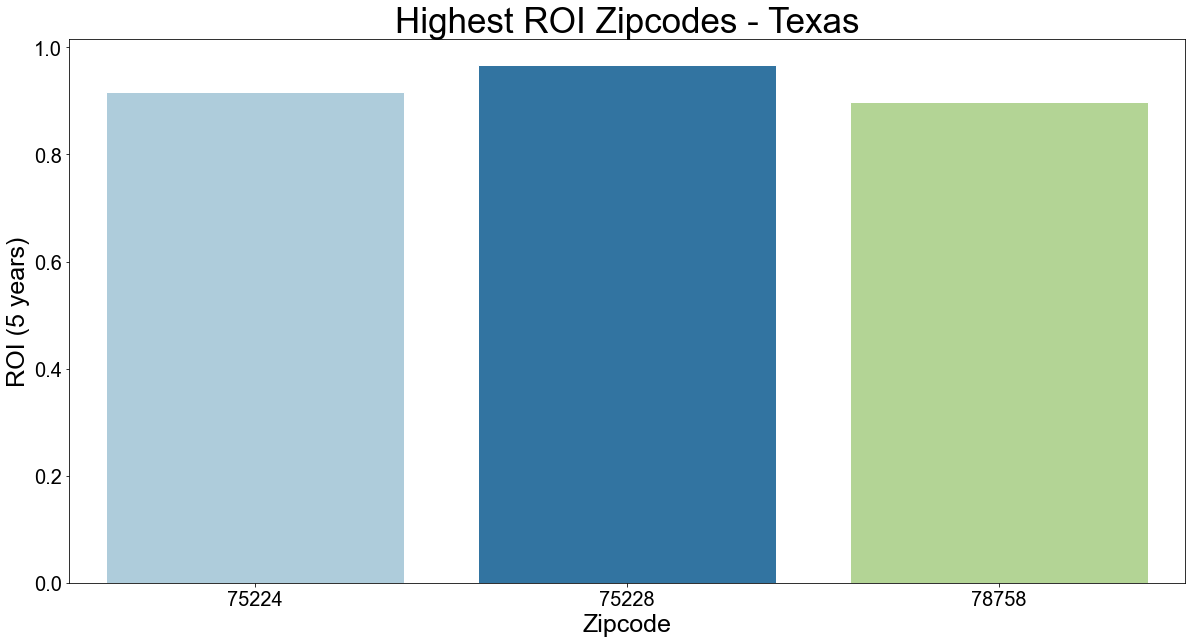

In [23]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.set(style = 'white')
palette = sns.set_palette(sns.color_palette("Paired"))
p = sns.barplot(x = "Zipcode", y = 'ROI_5', data = TX_df3[:3], color = palette)
p.set_xlabel("Zipcode", fontsize = 25)
p.set_ylabel("ROI (5 years)", fontsize = 25)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
p.set_title("Highest ROI Zipcodes - Texas", fontsize = 35)

plt.show()

In [24]:
TX_map = folium.Map([32.82, -96.68], zoom_start = 6.3, width = '75%')
for lat, lon in zip(TX_df3['latitude'][:3], TX_df3['longitude'][:3]):
    folium.CircleMarker([lat, lon], radius = 10, color = 'darkred').add_to(TX_map)
TX_map

In [26]:
# Top 3 Zip Codes Time Series

df75224 = TX_df3[TX_df3['Zipcode']== 75224]
df75224.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-12,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population,yr_avg,ROI_5
3795,90776,75224,Dallas,TX,Dallas-Fort Worth,Dallas,3796,57200.0,57300.0,57300.0,...,147300,149100,150200,151300,152600,32.71,-96.84,28820,111929.655833,0.9171


In [27]:
df75228 = TX_df3[TX_df3['Zipcode']== 75228]

In [29]:
df75228 = TX_df3[TX_df3['Zipcode']== 75228]

In [28]:
df78758 = TX_df3[TX_df3['Zipcode']== 78758]

In [32]:
#Utilizing the get_datetimes function given from the starter notebook
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[7:-5], format='%Y-%m')


In [33]:
get_datetimes(df78758)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [34]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!


In [35]:
# melt_data function from the Starter notebook
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['Zipcode', 'RegionID', 'SizeRank', 'City', 'State', 
                                  'Metro', 'CountyName','latitude', 'longitude', 'irs_estimated_population','yr_avg', 'ROI_5']
                                 , var_name='Date')
    melted['Date'] = pd.to_datetime(melted['Date'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('Date').aggregate({'value':'mean'}) 

In [36]:
melted_78758 = melt_data(df78758)
melted_78758

,value
Date,
1996-04-01,129000.0
1996-05-01,128300.0
1996-06-01,127500.0
1996-07-01,126900.0
1996-08-01,126300.0
...,...
2017-12-01,250500.0
2018-01-01,255100.0
2018-02-01,260100.0


findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

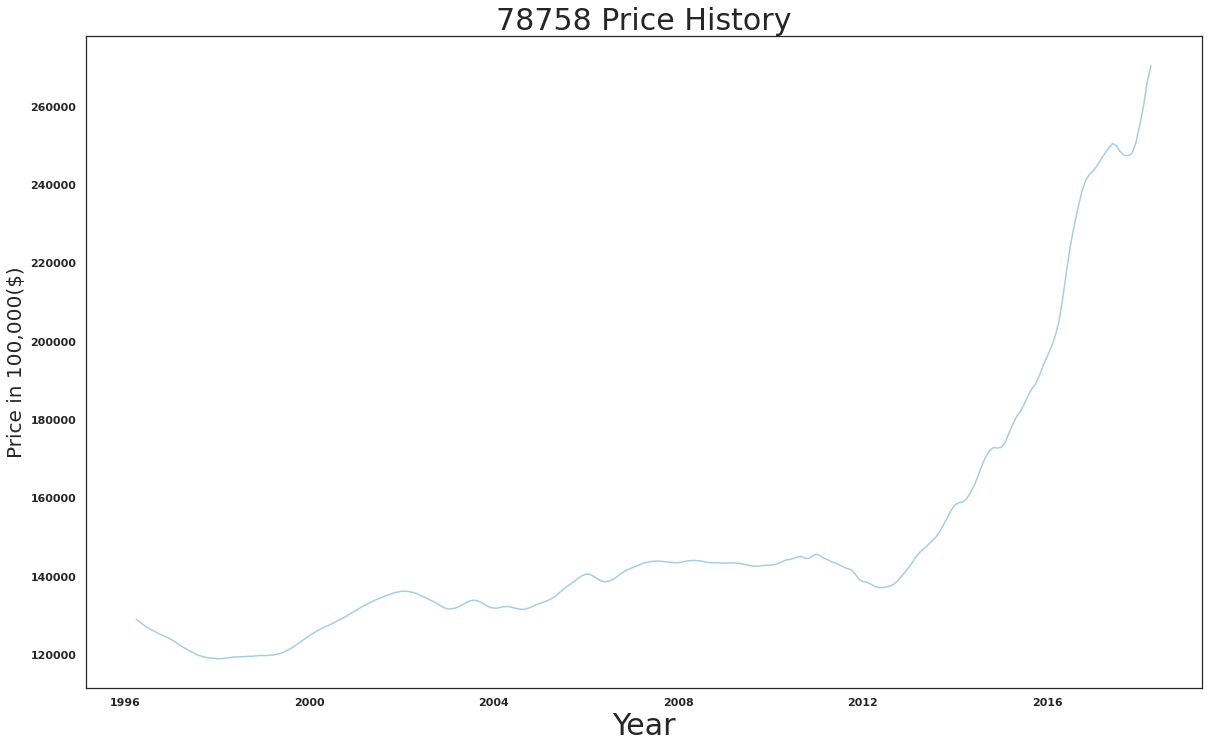

In [37]:
fig, ax = plt.subplots(figsize=(20,12))
ax.plot(melted_78758)

ax.set_xlabel('Year', fontsize=30)
ax.set_ylabel('Price in 100,000($)',fontsize=20)
ax.set_title('78758 Price History',fontsize=30);

In [39]:
melted_TX = melt_data(TX_dff1)

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

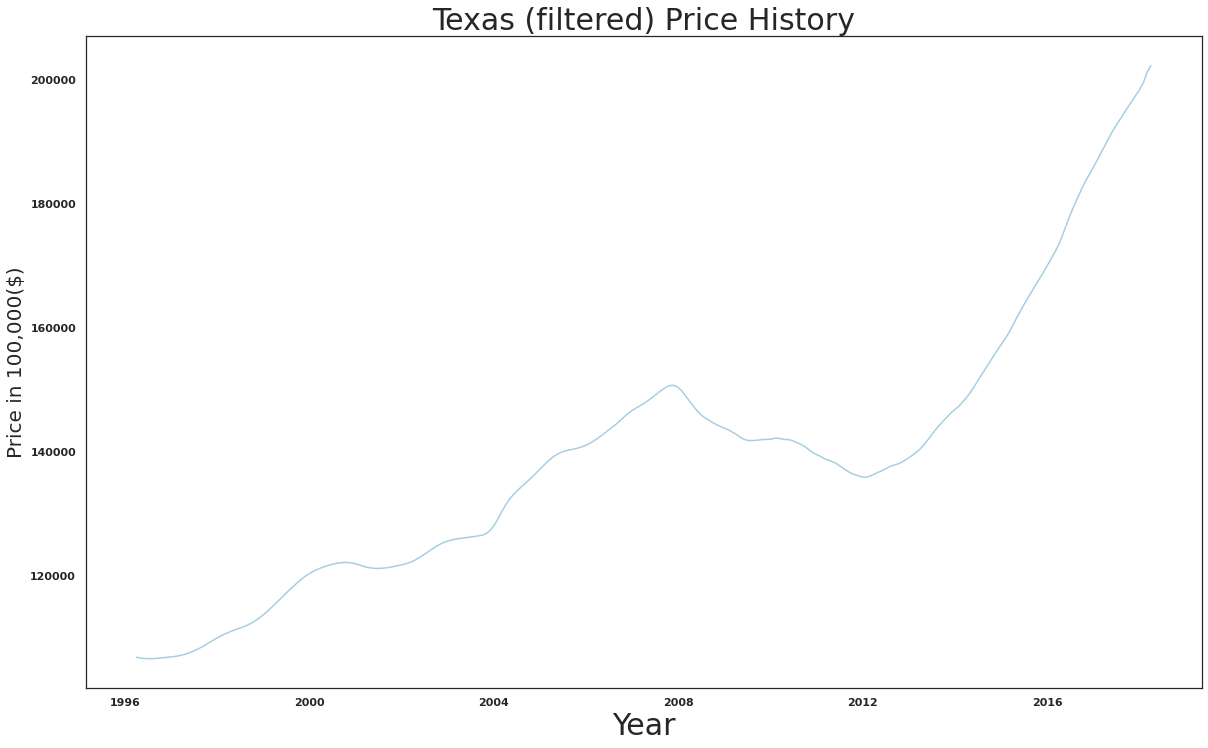

In [40]:
fig, ax = plt.subplots(figsize=(20,12))
ax.plot(melted_TX)

ax.set_xlabel('Year', fontsize=30)
ax.set_ylabel('Price in 100,000($)',fontsize=20)
ax.set_title('Texas (filtered) Price History',fontsize=30);

In [41]:
train_set = melted_TX[:'2015-12']
val_set = melted_TX['2016-01':]

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

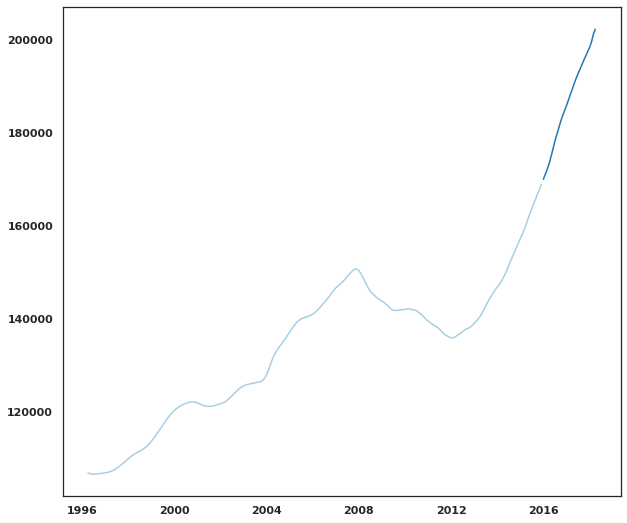

In [42]:
fig, ax = plt.subplots(figsize=(10, 9))
ax.plot(train_set, label = 'train')
ax.plot(val_set, label = 'test')


In [43]:
split = TimeSeriesSplit()

# The ARIMA Models

In [44]:
#First Model
ar1 = ARIMA(train_set, order = (1, 1, 1)).fit()
ar1_pred = ar1.predict(typ='levels')

/Users/henryshin/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/henryshin/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/henryshin/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [45]:

ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  237
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1485.510
Date:                Thu, 27 Oct 2022   AIC                           2977.020
Time:                        08:21:45   BIC                           2987.412
Sample:                    04-01-1996   HQIC                          2981.209
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8792      0.005    190.975      0.000       0.870       0.888
ma.L1          0.7650      0.022     35.166      0.000       0.722       0.808
sigma2      1884.4744     82.258     22.909      0.000    1723.251    2045.698
===================================================================================
Ljung-Box (L1) (Q):                  15.67   Jarque-Bera (JB):             11924.57
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                            -3.71
Prob(H) (two-sided):                  0.30   Kurtosis:                        37.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
#Second Model

ar2 = ARIMA(train_set, order = (0, 1, 1)).fit()
ar2.predict(typ='levels')

/Users/henryshin/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/henryshin/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/henryshin/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/henryshin/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting M

1996-04-01         0.000000
1996-05-01    109180.219345
1996-06-01    106382.142908
1996-07-01    106707.103960
1996-08-01    106616.922345
                  ...      
2015-08-01    163836.308784
2015-09-01    164910.519418
2015-10-01    165939.723299
2015-11-01    166961.699775
2015-12-01    167944.892694
Freq: MS, Name: predicted_mean, Length: 237, dtype: float64

In [47]:
ar2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  237
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1783.544
Date:                Thu, 27 Oct 2022   AIC                           3571.089
Time:                        08:23:51   BIC                           3578.016
Sample:                    04-01-1996   HQIC                          3573.881
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1514      0.008     20.180      0.000       0.137       0.166
sigma2      1.683e+05   1.71e+04      9.854      0.000    1.35e+05    2.02e+05
===================================================================================
Ljung-Box (L1) (Q):                 148.76   Jarque-Bera (JB):               511.82
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.95   Skew:                            -1.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
#Third Model
ar3 = ARIMA(train_set, order = (0, 1, 0)).fit()
ar3.predict(typ='levels')

/Users/henryshin/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/henryshin/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/henryshin/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


1996-04-01         0.000000
1996-05-01    106857.073171
1996-06-01    106743.902439
1996-07-01    106664.390244
1996-08-01    106628.780488
                  ...      
2015-08-01    163692.195122
2015-09-01    164769.268293
2015-10-01    165804.390244
2015-11-01    166827.317073
2015-12-01    167815.609756
Freq: MS, Name: predicted_mean, Length: 237, dtype: float64

In [49]:
ar3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  237
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1798.132
Date:                Thu, 27 Oct 2022   AIC                           3598.265
Time:                        08:24:26   BIC                           3601.729
Sample:                    04-01-1996   HQIC                          3599.661
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.419e+05   2.42e+04      9.992      0.000    1.94e+05    2.89e+05
===================================================================================
Ljung-Box (L1) (Q):                 226.23   Jarque-Bera (JB):                 0.38
Prob(Q):                              0.00   Prob(JB):                         0.83
Heteroskedasticity (H):               3.90   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
# Predictions and using mean_squared_error for our metric

yhat_ar1 = ar1.predict(typ='levels')
np.sqrt(mean_squared_error(train_set, yhat_ar1))

6943.28823130417

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

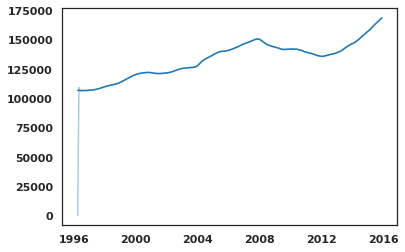

In [51]:
fig, ax = plt.subplots()
ax.plot(ar1_pred)
ax.plot(train_set)

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

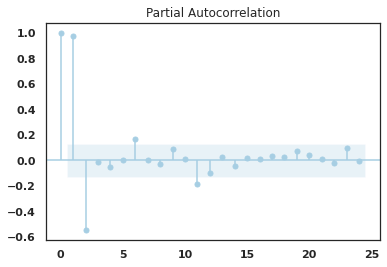

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

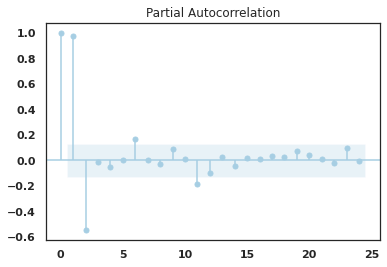

In [52]:
plot_pacf(train_set.diff().dropna())

<AxesSubplot: xlabel='Date'>

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

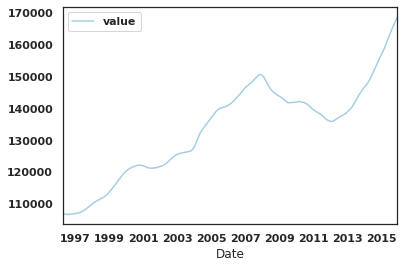

In [53]:
train_set.plot()

<AxesSubplot: xlabel='Date'>

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

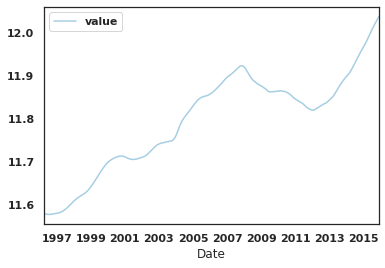

In [54]:
np.log(train_set).plot()

<AxesSubplot: xlabel='Date'>

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

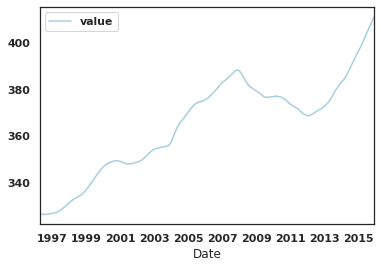

In [55]:
np.sqrt(train_set).plot()

In [56]:
decomposition = seasonal_decompose(np.log(train_set))
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

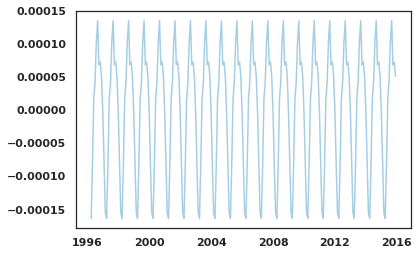

In [57]:
plt.plot(seasonal)


findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

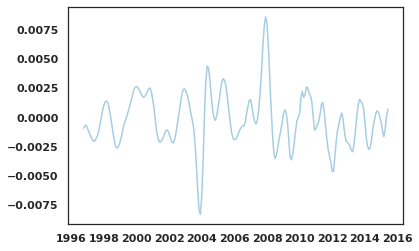

In [58]:
plt.plot(residual)


In [59]:
train_log_dec = residual
train_log_dec = train_log_dec.dropna()

In [60]:
# Utlizing the dickey-fuller test
dftest = adfuller(train_log_dec)

In [61]:
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  -4.674201
p-value                          0.000094
#Lags Used                       5.000000
Number of Observations Used    219.000000
Critical Value (1%)             -3.460567
Critical Value (5%)             -2.874830
Critical Value (10%)            -2.573853
dtype: float64


In [62]:
data_transform = np.sqrt(train_set)
diff = data_transform.diff().dropna()

In [63]:
pd.DataFrame(np.hstack((data_transform[1:].values.reshape(-1, 1),diff.values.reshape(-1,1))))


,0,1
0,326.716854,-0.173148
1,326.595147,-0.121706
2,326.540626,-0.054521
3,326.545108,0.004482
4,326.588426,0.043318
...,...,...
231,405.917810,1.328889
232,407.190852,1.273043
233,408.444999,1.254146
234,409.653036,1.208037


In [64]:
adfuller(diff)


(-1.7939065063136974,
 0.38349111318165074,
 4,
 231,
 {'1%': -3.4589796764641,
  '5%': -2.8741347158661448,
  '10%': -2.573482381701992},
 -594.4472343261457)